In [151]:
# Drop variables that don't seem to be contributing *or* much of them have problems
# (Wave 9 variables, high (anti-/)correlation variables, mostly not filled out, very low variance, too many categories)
# Transform variables (making some more easily readable
# and dummying non-ordinal categorical variables to create lots of new variables)
# rechecking if those new variables suffer from excessive levels of correlation

# Output: 
# BES_reduced - imputed dataset post-transformation
# BES_reduced_with_na - non-imputed dataset post-transformation


In [152]:
# import numpy as np
# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# import gc
# import re

# from itertools import cycle
# from IPython.display import display
# import pickle, os

# import seaborn as sns

# encoding = "ISO-8859-1"

# import Jupyter_module_loader

# from utility import *

In [153]:
# # you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

# if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
#     raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

# BES_code_folder   = "../BES_analysis_code/" # we should be here!
# BES_small_data_files = BES_code_folder + "small data files" + os.sep
# if not os.path.exists( BES_small_data_files ):
#     os.makedirs( BES_small_data_files )

# # we should create these if they don't already exist
# BES_data_folder   = "../BES_analysis_data/"
# if not os.path.exists( BES_data_folder ):
#     os.makedirs( BES_data_folder )

# BES_output_folder = "../BES_analysis_output/"
# if not os.path.exists( BES_output_folder ):
#     os.makedirs( BES_output_folder )
    
# BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [154]:
# dataset_name = "W19_comb"

In [155]:
# # %%time

# manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

# data_subfolder = BES_data_folder + dataset_name + os.sep

# filename = manifest["Stata_Filename"].values[0]

# BES_Panel  = pd.read_pickle(data_subfolder + filename.replace('.dta','.zip'),compression='zip')
# print("BES_Panel", BES_Panel.shape )


# # BES_numeric = pd.read_msgpack( data_subfolder + "BESnumeric.msgpack" )
# BES_numeric = pd.read_pickle( data_subfolder + "BESnumeric.zip", compression='zip' )
# print("BES_numeric",  BES_numeric.shape )

# try:
#     var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
#     var_type.set_index("Unnamed: 0", inplace=True)
# except:
#     var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
# print("var_type",  var_type.shape )

# fname = data_subfolder + "cat_dictionary.pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )

In [156]:
# BES_Panel = pd.read_stata('..\\BES_analysis_data\\W25_only\\BES2019_W25_v25.0.dta')
# BES_Panel.to_pickle('..\\BES_analysis_data\\W25_only\\BES2019_W25_v25.0.zip',compression='zip')

In [157]:
# %%time
dataset_name = "W29_only"
df_list = 'BES_Panel|BESnumeric'
%matplotlib inline
%run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)  
try:
    var_type    = pd.read_msgpack( data_subfolder + "var_type.msgpack")
except:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

Toggle code

var_type (474, 13)
old_new_col_names not loaded
var_type (474, 13)


<Figure size 640x480 with 0 Axes>

In [158]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [159]:
# ## somewhere better for this

###################################################


# reader = pd.io.stata.StataReader(BES_data_folder+"W19_comb//"+"BES2019_W19_Panel_v0.2.dta")

# header = reader.variable_labels()
# labels = reader.value_labels()

# pd.Series(header).to_pickle(BES_data_folder+"W19_comb//"+"column_description.zip",compression='zip')
# import pickle
# with open(BES_data_folder+"W19_comb//"+"variable_labels.zip", 'wb') as handle:
#     pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [160]:
BES_numeric=BESnumeric
del BESnumeric

# BES_Panel = BES_Panel_clean
# del BES_Panel_clean


In [161]:
# BES_numeric.dtypes.value_counts()

In [162]:
# BES_numeric.shape

In [163]:
%%time
medians = BES_numeric.astype('float32').median()

CPU times: total: 31.2 ms
Wall time: 147 ms


In [164]:
# BES_numeric.dtypes.apply(lambda x: str(x.name)).to_dict()

In [165]:
%%time
BES_imputed = BES_numeric.astype( 'float32' ).fillna(medians)
gc.collect()

CPU times: total: 78.1 ms
Wall time: 231 ms


4

In [166]:
BES_imputed = BES_imputed.apply(lambda x: pd.to_numeric( x , downcast='unsigned' ) )

In [167]:
BES_imputed.dtypes.value_counts()

uint8      449
float32      6
uint16       2
Name: count, dtype: int64

In [168]:
# BES_imputed = BES_numeric.fillna(medians)
# print("BES_imputed",  BES_imputed.shape )

In [169]:
# %%time
# imputation_method = "mice" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave

# imputation_method = "median" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave


# BES_imputed = pd.read_hdf( BES_data_folder + imputed_file_name  + ".hdf", imputed_file_name )
# BES_numeric.replace(-1,np.nan,inplace=True)
# BES_imputed = BES_numeric.fillna(BES_numeric.median())


In [170]:
# bool_vars = BES_numeric.columns[BES_numeric.dtypes=="boolean"]
# BES_numeric[bool_vars] = BES_numeric[bool_vars].astype('Int8')

In [171]:
# England_inds = BES_Panel[BES_Panel["country"]=="England"].index
# print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
# Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
# Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
# Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
# Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
# print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
# Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
# EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )

In [172]:
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
# print ( "W9 columns: ", W9_vars )

In [173]:
# W9_vars = []

In [174]:
opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
many_cat_drop_list = opts_per_cat[opts_per_cat>60].index
# added to make sure we're only dropping *categorical* variables with lots of categories!
many_cat_drop_list = [x for x in var_type.loc[many_cat_drop_list].index
                      if var_type.loc[many_cat_drop_list].loc[x]["type"] in [3,7]]
print("many_cat_drop_list", many_cat_drop_list )

many_cat_drop_list ['new_pcon', 'pcon']


In [175]:
many_cat_drop_list

['new_pcon', 'pcon']

In [176]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [177]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()

In [178]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

CPU times: total: 62.5 ms
Wall time: 96.1 ms


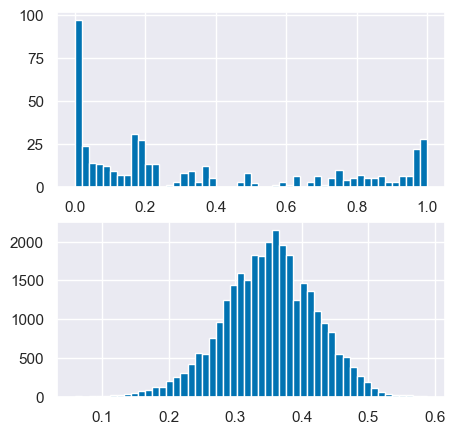

In [179]:
%%time
# columns histogrammed by %non-missing values
# rows histogrammed by %non-missing values

counts = BES_numeric.count()/BES_numeric.shape[0]
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
ax = axarr[0].hist(counts,bins=50)
ax = axarr[1].hist(counts_by_individuals,bins=50)

In [180]:
# In theory, this is picked on the basis of looking at the above two diagrams (really, the top one!)
# thresh = 0.33
# missing_value_thresh = 0.33
missing_value_thresh = 0.05

mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [181]:
# missing_value_thresh = 0.8

# mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
# mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [182]:
print(BES_numeric[mostly_filled_out].shape)
missing_fraction = BES_numeric[mostly_filled_out].isnull().sum().sum() / \
    (BES_numeric[mostly_filled_out].shape[0]*BES_numeric[mostly_filled_out].shape[1])
print(missing_fraction)

(31098, 326)
0.5137167797664774


In [183]:
# %%time
# frac=.2
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).shape
# np.corrcoef( BES_numeric.sample(frac=frac).sample(frac=frac, axis=1) )
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).corr(min_periods=100, method='pearson')



In [184]:
def memory_cheap_corrcoef(x):
    rowvar=True
    m = np.asarray(x)
    dtype = np.result_type(m, np.float32)
    X = np.array(m, ndmin=2, dtype=dtype).T
    fact = X.shape[1]
    avg = np.average(X, axis=1, returned=True)
    X-= avg[0][:,None]
    c = np.dot(X, X.T.conj())/fact
    # c *= np.true_divide(1, fact)
    c= c.squeeze()    
    
    try:
        d = np.diag(c)
    except ValueError:
        # scalar covariance
        # nan if incorrect value (nan, inf, 0), 1 otherwise
        return c / c
    stddev = np.sqrt(d.real)
    c /= stddev[:, None]
    c /= stddev[None, :]

    # Clip real and imaginary parts to [-1, 1].  This does not guarantee
    # abs(a[i,j]) <= 1 for complex arrays, but is the best we can do without
    # excessive work.
    np.clip(c.real, -1, 1, out=c.real)
    if np.iscomplexobj(c):
        np.clip(c.imag, -1, 1, out=c.imag)

    return c



In [185]:
# np.array(m, ndmin=2, dtype=dtype)

In [186]:
memory_use(locs = locals().items())

           BES_reduced_with_na: 180.0MiB
                   BES_numeric: 108.4MiB
                     BES_Panel:  23.0MiB
                   BES_reduced:  22.5MiB
                   BES_imputed:  14.1MiB
                      corr_mat:   2.2MiB
                         corrs:   2.1MiB
                          mask: 548.0KiB
                      var_type: 414.9KiB
         counts_by_individuals: 243.1KiB


In [187]:
# BES_imputed.loc[BES_imputed.index[::2]]

In [188]:
%%time
corrs = memory_cheap_corrcoef(BES_imputed.astype('float32'))
corr_mat = pd.DataFrame(corrs,index=BES_imputed.columns, columns=BES_imputed.columns)
corr_mat.to_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compression='zip')
# .loc[BES_imputed.index[::4]]

CPU times: total: 250 ms
Wall time: 135 ms


In [189]:
# corrs.shape
# corr_mat = pd.DataFrame(corrs,index=BES_imputed.columns, columns=BES_imputed.columns)
# corr_mat.to_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compression='zip')

In [190]:
# pd.DataFrame(corrs,

In [191]:
# %%time
# # 0.05, 0.0025: 2.34
# # 0.10, 0.01: 10.7s
# # 0.10, spearman: 27s
# # 0.10, kendall: 56s
# # 0.15, 0.0225, pearson: 29s
# # 0.20, 0.04, pearson: 65s
# # 30 mins?
# # W14_only: 55s
# try:
#     corr_mat = pd.read_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compression='zip')
# except:
#     corr_mat = BES_numeric.corr()
#     corr_mat.to_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compression='zip')

CPU times: total: 0 ns
Wall time: 41.1 ms


<Axes: >

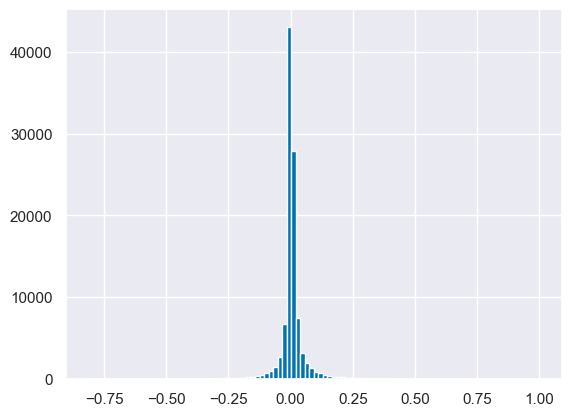

In [192]:
%%time
## 5 minutes!
## 8h 41min 19s on W10_comb panel!

# data = BES_numeric
# corr_mat = BES_numeric.corr()

# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [193]:
# build a data frame of pairs of highly corr/anti-corr variables
# score on correlation, %non-missing values for each
# Building the high_corr_list is still **manual** (not much reason to automate)


corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])

id_num = 0

# min_filled_out = 0.02
min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out:
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1

corr_df

,var1,var2,corr,var1%,var2%,min var%
0,voted_ge_2024,genElecTurnoutRetro,0.967328,0.994115,0.997331,0.994115
1,ns_sec_analytic_parent,ns_sec_parent,0.984495,0.474146,0.474146,0.474146
2,ns_secW26W27,ns_sec_analyticW26W27,0.981074,0.631230,0.631230,0.631230
3,ageGroup,age,0.974586,1.000000,1.000000,1.000000
4,p_edlevelUni,p_edlevel,0.999454,0.870345,0.867869,0.867869


In [194]:
# corr_df.to_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")


In [195]:
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,voted_ge_2024,genElecTurnoutRetro,0.967328,0.994115,0.997331,0.994115
1,ns_sec_analytic_parent,ns_sec_parent,0.984495,0.474146,0.474146,0.474146
2,ns_secW26W27,ns_sec_analyticW26W27,0.981074,0.631230,0.631230,0.631230
3,ageGroup,age,0.974586,1.000000,1.000000,1.000000
4,p_edlevelUni,p_edlevel,0.999454,0.870345,0.867869,0.867869


In [196]:
# corr_df = pd.read_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")

In [197]:
corr_df.sort_values(by="min var%",ascending=False).head(70)

,var1,var2,corr,var1%,var2%,min var%
3,ageGroup,age,0.974586,1.000000,1.000000,1.000000
0,voted_ge_2024,genElecTurnoutRetro,0.967328,0.994115,0.997331,0.994115
4,p_edlevelUni,p_edlevel,0.999454,0.870345,0.867869,0.867869
2,ns_secW26W27,ns_sec_analyticW26W27,0.981074,0.631230,0.631230,0.631230
1,ns_sec_analytic_parent,ns_sec_parent,0.984495,0.474146,0.474146,0.474146


In [198]:
corr_df[corr_df["min var%"]>missing_value_thresh]

,var1,var2,corr,var1%,var2%,min var%
0,voted_ge_2024,genElecTurnoutRetro,0.967328,0.994115,0.997331,0.994115
1,ns_sec_analytic_parent,ns_sec_parent,0.984495,0.474146,0.474146,0.474146
2,ns_secW26W27,ns_sec_analyticW26W27,0.981074,0.631230,0.631230,0.631230
3,ageGroup,age,0.974586,1.000000,1.000000,1.000000
4,p_edlevelUni,p_edlevel,0.999454,0.870345,0.867869,0.867869


In [199]:
# np.linalg.matrix_rank(BES_imputed.values),BES_imputed.shape

In [200]:
# BES_imputed.columns[ BES_imputed.isnull().all() ]

In [201]:
# BES_Panel["JACS_subjectW19"].value_counts()


In [202]:
# list( search(BES_Panel,"p_edlevelW\d+").index )

In [203]:
high_corr_drop_list = []

for ind in corr_df.index:
    if corr_df.loc[ind]["var1%"] == corr_df.loc[ind]["var2%"]: # prefer age over ageGroup
        options = set(corr_df.loc[ind][["var1" , "var2"]].values)
        if 'age' in options:
#             print(ind, list(options.difference(['age']))[0] )
            high_corr_drop_list.append( list(options.difference(['age']))[0] )
    elif corr_df.loc[ind]["var1%"] < corr_df.loc[ind]["var2%"]:
#         print(ind, corr_df.loc[ind]["var1"])
        high_corr_drop_list.append( corr_df.loc[ind]["var1"] )
    else:
#         print(ind, corr_df.loc[ind]["var2"])
        high_corr_drop_list.append( corr_df.loc[ind]["var2"] )
    
high_corr_drop_list = list( set(high_corr_drop_list) ) # make unique
high_corr_drop_list

['p_edlevel', 'voted_ge_2024', 'ageGroup']

In [204]:
# high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
#                        'ageGroup', 'Age','xsexualityW10','JACS_subjectW19']
# high_corr_drop_list.extend(['p_edlevelW1', 'p_edlevelW2', 'p_edlevelW3', 'p_edlevelW4', 'p_edlevelW5', 'p_edlevelW6', 'p_edlevelW7', 'p_edlevelW8', 'p_edlevelW9', 'p_edlevelW10', 'p_edlevelW11', 'p_edlevelW12', 'p_edlevelW13', 'p_edlevelW14', 'p_edlevelW15', 'p_edlevelW16', 'p_edlevelW17', 'p_edlevelW18', 'p_edlevelW19'])
high_corr_drop_list = []

In [205]:
# pref_list ['age','euRefVote',]


# high_corr_drop_list = []

# if ('age' in BES_numeric.columns) and ('Age' in BES_numeric.columns):
#     high_corr_drop_list.extend('Age')
    
# if ('ageGroup' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')
    
# if ('euRefVote' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')    

# high_corr_drop_list.extend(['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
#                        'ageGroup', 'voted2015', "ns_sec" , 'recallVote15'])
# # # 
# # high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
# #                        'ageGroup', 'Age', 'profile_turnout_2015', "ns_sec" , 'profile_past_vote_2015',"euIDW9"]

# # high_corr_drop_list = ["euID","ageGroup","euRefpastVote","voted2015"]

In [206]:
### HIGH CORR DROP LIST OVERRIDE
# high_corr_drop_list = []

In [207]:
%%time
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
# a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

CPU times: total: 31.2 ms
Wall time: 78.9 ms


In [208]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars
# two_opt_cats
# many_cat_drop_list
# high_corr_drop_list
# mostly_not_filled_out
# mostly_filled_out

In [209]:
gc.collect()
# BES_numeric[BES_numeric.columns[0:1000]].var()

0

In [210]:
gc.collect()
a = BES_numeric.var()
# a[b].hist(bins=100)
very_low_var = BES_imputed.columns[a<a.quantile(.05)]

In [211]:
very_low_var = []

In [212]:
# mostly_not_filled_out =[]

In [213]:
# many_cat_drop_list =[]

In [214]:
gc.collect()

0

In [215]:
# high_corr_drop_list = []

In [216]:
# high_corr_drop_list

In [217]:
high_corr_drop_list = []

In [218]:
# Time to dump some variables!
# (The results of this may have been exported back to the Imputation script
# if it looks like nothing is happening, that's why!)


BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

# # Wave 9 stuff
# BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
# print("W9_vars", BES_reduced.shape)
# drop_cols = cols.difference(BES_reduced.columns)
# if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
# cols = BES_reduced.columns

# Categorical variables with a huge number of categories
BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables which are redundant through very high correlation with other variables
BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too many' missing values
BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too low' variance
BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(31098, 457)
many_cat_drop_list (31098, 455)
Index(['new_pcon', 'pcon'], dtype='object')
high_corr_drop_list (31098, 455)
mostly_not_filled_out (31098, 324)
very_low_var (31098, 324)


In [219]:
# necessary because some imputation types impute values outside of range of available values
# kind of suggests ... maybe not such good imputation methods??
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser

In [220]:
# problem
#  'xprofile_house_tenure': 'Own â\x80\x93 outright',

In [221]:
# reorder categories in a categorical variable so that the most numerous subcategory goes first
# so it can be dropped automatically when dummying
# also, return name of reference subcategory
def select_reference_subcategory(non_ordinal):
    order = BES_numeric[non_ordinal]\
        .dropna().astype('int').apply( lambda x: cat_dictionary[non_ordinal][x] ).value_counts().index
    return BES_reduced[non_ordinal].astype('category').cat.reorder_categories( order ), order[0]

In [222]:
# Recreate and rename categorical non_ordinal and ordinal variables:
# ordinal two categories -> one single dummy binary variable labelled with positive category name (e.g gender_female)
# ordinal 3+ category variables just renamed to append "__top_value" to variable name
# non-ordinal 3+ categories -> split to individual dummy binary variables "category_subcateory"

# need to create a dict of new_variable_names with old col names
# to allow reinsertion of missing values, say
new_old_col_names = dict()
# we need to drop one sub-category for each categorical variable we dummy
# advice supports obvious guess - always choose most numerous subcategory to the reference subcategory
non_ordinal_base_subcat = dict()


In [223]:
# NON-ORDINAL CATEGORICAL VARIABLES
# get split into one variable for each category
# NOTE: Dummy variable/multicollinearity trap
# we need to choose a base variable for each category and drop it!
drop_reference = False

non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    # return to text categories!
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])
    # reorder to place most numerous subcategory first
    BES_reduced[non_ordinal], non_ordinal_base_subcat[non_ordinal] = \
        select_reference_subcategory( non_ordinal  )
    
    # create dictionary so we have a record of which variable all newly generated ones come from!
    for subcat in cat_dictionary[non_ordinal]:
        new_col_name = non_ordinal + "_" + subcat
        new_old_col_names[new_col_name] = non_ordinal

if drop_reference == True:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=True ) 
else:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=False )
    

In [224]:
# BINARY CATEGORICAL VARIABLES
# get renamed with 'top' value separated by single underscore
# (this is the same as with non-ordinal variables - maybe use a different convention - like ___)
# i.e. haveDependents -> haveDependents_No

two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    
    new_col_name = col + "_" + cat_dictionary[col][1]
    new_old_col_names[new_col_name] = col
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )

In [225]:
# ORDINAL CATEGORICAL VARIABLES
# get renamed with 'top' value separated by double underscore
# i.e. likeBoris -> likeBoris__Strongly Agree

ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    new_old_col_names[new_col_name] = ordinal
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (31098, 749)


In [226]:
# save decomp object    
fname = data_subfolder + "new_old_col_names.pkl"

with open(fname, "wb") as f:
    pickle.dump( new_old_col_names, f )

In [227]:
memory_use(locs = locals().items())

           BES_reduced_with_na: 180.0MiB
                   BES_numeric: 108.4MiB
                     BES_Panel:  23.0MiB
                   BES_reduced:  22.2MiB
                   BES_imputed:  14.1MiB
                      corr_mat: 864.5KiB
                            df: 816.0KiB
                         corrs: 815.9KiB
                      var_type: 414.9KiB
         counts_by_individuals: 243.1KiB


In [228]:
memory_use(locs = locals().items())

           BES_reduced_with_na: 180.0MiB
                   BES_numeric: 108.4MiB
                     BES_Panel:  23.0MiB
                   BES_reduced:  22.2MiB
                   BES_imputed:  14.1MiB
                      corr_mat: 864.5KiB
                            df: 816.0KiB
                         corrs: 815.9KiB
                      var_type: 414.9KiB
         counts_by_individuals: 243.1KiB


In [229]:
BES_reduced.dtypes.value_counts()

bool     597
uint8    152
Name: count, dtype: int64

In [230]:
# BES_reduced_with_na.dtypes.value_counts()

In [231]:
%%time
## slow! 2h 47min 41s

# 4h 19min 35s!!!?


## We should do correlation testing on a version with missing values
## and may also wish an output with missing values (e.g. to run weightedPCA on)
## Which means reinserting missing values

BES_reduced_with_na = BES_reduced.copy()
BES_reduced_with_na.index = BES_Panel.index

col_list = []

for col in BES_reduced_with_na:
    if col in new_old_col_names.keys():
        old_col = new_old_col_names[col]
        col_list.append(old_col)
#         null_series = BES_numeric[old_col].isnull()
    else:
        col_list.append(col)
#         null_series = BES_numeric[col].isnull()


# BES_reduced_with_na.loc[null_series,col] = np.nan
BES_reduced_with_na.where( BES_numeric[col_list].notnull().values,other =np.nan, inplace=True )

    
    # 2 option ordinal (name change)
    # 3+ option ordinal (name change)
    # categorical (split into lots of variables)
    # other (no name change)

CPU times: total: 141 ms
Wall time: 313 ms


In [232]:
BES_reduced_with_na.shape, len(col_list)

((31098, 749), 749)

In [233]:
BES_numeric.isnull().sum()

generalElectionVote             4926
generalElectionVoteNonVoter    28905
partyId                         1752
partyIdSqueeze                 22740
partyIdStrength                 6607
                               ...  
p_turnout_2005                 10489
p_turnout_scot_ref             21007
p_edlevel                       4109
p_edlevelUni                    4032
p_eurefturnout                   387
Length: 457, dtype: int64

In [234]:
BES_reduced_with_na.isnull().sum().sort_values()

mii_cat_llm_12.0                                       0
mii_cat_llm_17.0                                       0
mii_cat_llm_48.0                                       0
mii_cat_llm_27.0                                       0
mii_cat_llm_28.0                                       0
                                                   ...  
welshElectionVoteNew_Abolish the Assembly Party    29541
welshElectionVoteNew_Reform UK                     29541
welshElectionVoteNew_Labour                        29541
welshElectionVoteNew_Liberal Democrat              29541
welshElectionVoteNew_Plaid Cymru                   29541
Length: 749, dtype: int64

In [235]:
BES_reduced.isnull().sum().sort_values()

partyIdStrength__Not very strong                                                  0
p_marital_In a relationship, but not living together                              0
p_marital_Separated but still legally married or in a civil partnership           0
p_marital_In a civil partnership                                                  0
p_religion_No, I do not regard myself as belonging to any particular religion.    0
                                                                                 ..
mii_cat_llm_15.0                                                                  0
mii_cat_llm_33.0                                                                  0
mii_cat_llm_23.0                                                                  0
mii_cat_llm_46.0                                                                  0
preschoolKidsInHouseW26_Yes                                                       0
Length: 749, dtype: int64

In [236]:
col_list

['partyIdStrength',
 'anyUniW26W27',
 'voteMethoda',
 'polAttention',
 'pidWeThey',
 'pidInterestedOthers',
 'pidCriticiseParty',
 'pidCommonParty',
 'pidConnected',
 'pidPraiseGood',
 'pidWeTheyb',
 'pidInterestedOthersb',
 'pidCriticisePartyb',
 'pidCommonPartyb',
 'pidConnectedb',
 'pidPraiseGoodb',
 'likeSunak',
 'likeStarmer',
 'likeDavey',
 'likeSwinney',
 'likeFarage',
 'likeRamsay',
 'likeDenyer',
 'likeCon',
 'likeLab',
 'likeLD',
 'likeSNP',
 'likePC',
 'likeBrexitParty',
 'likeGrn',
 'econPersonalProsp',
 'econGenProsp',
 'econPersonalRetro',
 'econGenRetro',
 'EUIntegrationSelf',
 'EUIntegrationCon',
 'EUIntegrationLab',
 'EUIntegrationLD',
 'EUIntegrationSNP',
 'EUIntegrationGreen',
 'EUIntegrationBrexit',
 'leftRight',
 'satDemUK',
 'satDemScot',
 'satDemWales',
 'satDemEng',
 'redistSelf',
 'redistCon',
 'redistLab',
 'redistLD',
 'redistSNP',
 'redistBrexit',
 'redistGreen',
 'immigSelf',
 'immigCon',
 'immigLab',
 'immigLD',
 'immigSNP',
 'immigBrexit',
 'immigGreen',


In [237]:
%%time
BES_reduced_with_na = BES_reduced_with_na.where( BES_numeric[col_list].notnull().values,other =np.nan )


CPU times: total: 141 ms
Wall time: 286 ms


In [238]:
BES_reduced_with_na.isnull().sum()

partyIdStrength__Not very strong                          6607
anyUniW26W27__Yes, I graduated from higher education      6411
voteMethoda__Someone else voted for me (proxy voting)     4122
polAttention__Pay a great deal of attention                185
pidWeThey__Strongly agree                                19547
                                                         ...  
voted_ge_2024_Yes                                          183
achieveIncGrowthNone_Yes                                 25716
achieveIncGrowthBrexit_Yes                               25716
achieveIncGrowthGrn_Yes                                  25716
preschoolKidsInHouseW26_Yes                               5952
Length: 749, dtype: int64

In [239]:
BES_numeric[col_list].shape,BES_reduced_with_na.shape

((31098, 749), (31098, 749))

In [240]:
BES_reduced_with_na[BES_reduced_with_na.columns[0:2]].shape,BES_numeric[col_list[0:2]].shape

((31098, 2), (31098, 2))

In [241]:
BES_reduced_with_na[BES_reduced_with_na.columns[0:2]].where( BES_numeric[col_list[0:2]].notnull(), other =np.nan ).isnull().sum()

partyIdStrength__Not very strong                        31098
anyUniW26W27__Yes, I graduated from higher education    31098
dtype: int64

In [242]:
BES_numeric[col_list[0:2]].isnull().sum()

partyIdStrength    6607
anyUniW26W27       6411
dtype: int64

In [243]:
BES_reduced_with_na[BES_reduced_with_na.columns[0:2]].where( cond=BES_numeric[col_list[0:2]].notnull().values, other =np.nan ).isnull().sum()

partyIdStrength__Not very strong                        6607
anyUniW26W27__Yes, I graduated from higher education    6411
dtype: int64

In [244]:
BES_numeric[col_list[0:2]].notnull()

,partyIdStrength,anyUniW26W27
0,True,True
1,True,True
2,True,True
3,True,True
4,True,False
...,...,...
31093,True,True
31094,False,True
31095,False,True
31096,False,True


In [245]:
BES_reduced_with_na.dtypes.value_counts()

object     534
float64    150
bool        63
uint8        2
Name: count, dtype: int64

In [246]:
BES_reduced.dtypes.value_counts()

bool     597
uint8    152
Name: count, dtype: int64

In [247]:
float64_vars = BES_reduced_with_na.columns[BES_reduced_with_na.dtypes=='float64']

In [248]:
BES_reduced_with_na[float64_vars] = BES_reduced_with_na[float64_vars].astype('float32')

In [249]:
# BES_numeric.dtypes

In [250]:
dtypes = pd.Series([BES_numeric[new_old_col_names[x]].dtype.name  if x in new_old_col_names.keys() else BES_numeric[x].dtype.name for x in BES_reduced_with_na.columns])

In [251]:
dtypes.index = BES_reduced_with_na.columns

In [252]:
dtypes[BES_reduced_with_na.columns[[(x in new_old_col_names.keys()) and ("__" not in x) for x in BES_reduced_with_na.columns]]]='boolean'

In [253]:
dtypes_dict = dtypes.to_dict()

In [254]:
dtypes_dict

{'partyIdStrength__Not very strong': 'float64',
 'anyUniW26W27__Yes, I graduated from higher education': 'float64',
 'voteMethoda__Someone else voted for me (proxy voting)': 'float64',
 'polAttention__Pay a great deal of attention': 'float64',
 'pidWeThey__Strongly agree': 'float64',
 'pidInterestedOthers__Strongly agree': 'float64',
 'pidCriticiseParty__Strongly agree': 'float64',
 'pidCommonParty__Strongly agree': 'float64',
 'pidConnected__Strongly agree': 'float64',
 'pidPraiseGood__Strongly agree': 'float64',
 'pidWeTheyb__Strongly agree': 'float64',
 'pidInterestedOthersb__Strongly agree': 'float64',
 'pidCriticisePartyb__Strongly agree': 'float64',
 'pidCommonPartyb__Strongly agree': 'float64',
 'pidConnectedb__Strongly agree': 'float64',
 'pidPraiseGoodb__Strongly agree': 'float64',
 'likeSunak__Strongly like': 'float64',
 'likeStarmer__Strongly like': 'float64',
 'likeDavey__Strongly like': 'float64',
 'likeSwinney__Strongly like': 'float64',
 'likeFarage__Strongly like': 'flo

In [255]:
BES_reduced_with_na = BES_reduced_with_na.astype( dtypes_dict )

In [256]:
BES_reduced_with_na.isnull().sum().sort_values()

mii_cat_llm_12.0                                       0
mii_cat_llm_17.0                                       0
mii_cat_llm_48.0                                       0
mii_cat_llm_27.0                                       0
mii_cat_llm_28.0                                       0
                                                   ...  
welshElectionVoteNew_Abolish the Assembly Party    29541
welshElectionVoteNew_Reform UK                     29541
welshElectionVoteNew_Labour                        29541
welshElectionVoteNew_Liberal Democrat              29541
welshElectionVoteNew_Plaid Cymru                   29541
Length: 749, dtype: int64

In [257]:
# BES_reduced_with_na[col][~null_series]

In [258]:
## TEST CORRELATIONS
# we want to avoid having columns which are basically the same data
# through very high correlation/anti-correlation
# and when we find them, we want to keep the column with less missing values

<Axes: >

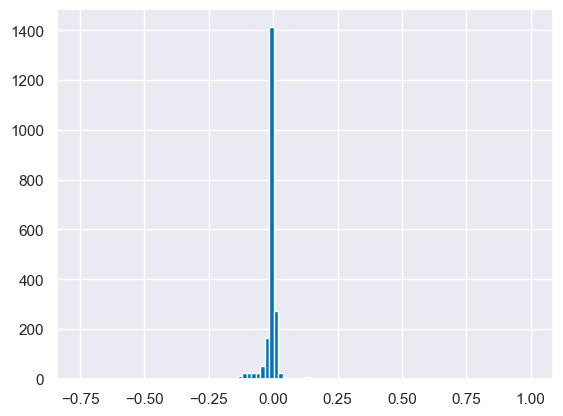

In [259]:
# %%time
# data = BES_reduced_with_na
# corr_mat = BES_reduced_with_na.corr()

corrs = memory_cheap_corrcoef(BES_reduced_with_na.astype('float32'))
corr_mat = pd.DataFrame(corrs,index=BES_reduced_with_na.columns, columns=BES_reduced_with_na.columns)
corr_mat.to_pickle(BES_data_folder+dataset_name+os.sep+"corr_df2.zip",compression='zip')
# .loc[BES_imputed.index[::4]]
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [260]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )    

('ageGroup__66+', 'age', 0.9745859, 1.0, 1.0)
('gor_Scotland', 'country_Scotland', 0.9999999, 1.0, 1.0)
('gor_Wales', 'country_Wales', 1.0, 1.0, 1.0)


In [261]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']

# dummy_cat_high_corr_drop_list = ['country_Wales', 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam']

BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
BES_reduced_with_na.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (31098, 747)
['country_Scotland', 'country_Wales']


In [262]:
# %%time
# nans = BES_numeric[[new_old_col_names[col] if col in new_old_col_names.keys() else col for col in BES_reduced.columns ]].isnull()
# nans.to_msgpack( data_subfolder + "nans.msgpack")
# del nans

In [263]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [264]:
# del BES_imputed, counts_by_individuals, corr_df

In [265]:
# import sys
# for var, obj in locals().items():
#     if ( sys.getsizeof(obj)> 1000000):
#         print(var, sys.getsizeof(obj))

In [266]:
# BES_reduced_with_na_2 = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
# BES_reduced_with_na_2.dtypes.value_counts()

In [267]:
########################################
########################################
## Pandas is trialling a new NAtype called pd.NA specifically just for missing values
## However, still experimental, so I'm going to replace it

In [268]:
BES_reduced_with_na = BES_reduced_with_na.astype('float').replace(pd.NA,np.nan)

In [269]:
gc.collect()

15

In [270]:
# BES_reduced_with_na.to_pickle( data_subfolder + "BES_reduced_with_na.zip",compression='zip')
BES_reduced.to_pickle( data_subfolder + "BES_reduced.zip",compression='zip')

In [271]:
gc.collect()
BES_reduced_with_na.to_pickle( data_subfolder + "BES_reduced_with_na.zip",compression='zip')

In [272]:
# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
# BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na2.msgpack")

In [273]:
# assert (BES_reduced==-1).sum().sum()==0
# BES_reduced = BES_reduced.apply(pd.to_numeric,downcast='integer')
# BES_reduced.to_msgpack( data_subfolder + "BES_reduced.msgpack")

In [274]:
# assert (BES_reduced_with_na==-1).sum().sum()==0
# # BES_reduced_with_na.fillna(-1,inplace=True)
# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='integer')
# BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

In [275]:
# save decomp object    
fname = data_subfolder + "new_old_col_names.pkl"

with open(fname, "wb") as f:
    pickle.dump( new_old_col_names, f )

In [276]:
# (BES_data_folder+"BES_reduced_with_na"+wave+".hdf","BES_reduced_with_na"+wave)


In [277]:
# del BES_numeric,BES_imputed,BES_reduced,BES_Panel,corr_mat,df,mask

In [278]:

# assert (BES_numeric==-1).sum().sum()==0
# BES_numeric.fillna(-1,inplace=True)
# BES_numeric = BES_numeric.apply(pd.to_numeric,downcast='integer')
# BES_numeric.to_msgpack( data_subfolder + "BESnumeric.msgpack")

In [279]:
# BES_reduced_with_na.stack().value_counts()

In [280]:
# var_type.loc['age']

In [281]:
gc.collect()

0

In [282]:
# np.linalg.matrix_rank( BES_reduced.drop(dummy_cat_high_corr_drop_list, axis=1, errors="ignore").values )

In [283]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").shape

In [284]:
# qr = np.linalg.qr(BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").values)[1]

In [285]:
# qr.shape

In [286]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").columns[np.abs(np.sum(qr,axis=1))<.3 ]

In [287]:
# dummy_cat_high_corr_drop_list.append('xprofile_ethnicity_Pakistani')

In [288]:
# dummy_cat_high_corr_drop_list

In [289]:
# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

In [290]:
# [x for x in BES_Panel.columns if 'age' in x.lower()]

In [291]:
# BES_Panel.shape[0]*.02

In [292]:
# BES_numeric["likeWoodW1"].notnull().sum()

In [293]:
# mostly_not_filled_out

In [294]:
# # a list of dropped variables!
# l = [many_cat_drop_list,
# high_corr_drop_list,
# mostly_not_filled_out,
# very_low_var]

# flat_list = [item for sublist in l for item in sublist]

# fname = data_subfolder + "red_dropped_var"
# with open(fname+".pkl", "wb") as f: pickle.dump( flat_list, f )

In [295]:

# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')


In [296]:
BES_reduced_with_na.dtypes.value_counts()

float64    747
Name: count, dtype: int64

In [297]:
memory_use(locs = locals().items())

           BES_reduced_with_na: 177.2MiB
                   BES_numeric: 108.4MiB
                     BES_Panel:  23.0MiB
                   BES_reduced:  22.2MiB
                   BES_imputed:  14.1MiB
                      corr_mat:   2.2MiB
                            df:   2.1MiB
                         corrs:   2.1MiB
                          mask: 548.0KiB
                      var_type: 414.9KiB


In [298]:
# BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

In [299]:
# del corr_mat, df



In [300]:
# BES_reduced_with_na